Kaggle Competition: https://www.kaggle.com/c/ieee-fraud-detection

A simple full process in Kaggle competition.

# Load Data 

Reference:

https://www.kaggle.com/nroman/lgb-single-model-lb-0-9419

https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-w-gpu

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from lightgbm import *
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import roc_auc_score

VERSION=1

Dataset in Kaggle is too large. We only use a small part of data for illustration.

In [2]:
%%time
import os

PATH= 'Data\\' 
def load_data(filename,path=PATH):
    return pd.read_csv(path+filename+'_sample.csv',index_col=0)
        
train_id=load_data("train_identity")
test_id=load_data("test_identity")
test_trans=load_data("test_transaction")
train_trans=load_data("train_transaction")
sample_sub=load_data("submission")

Wall time: 887 ms


In [3]:
train = pd.merge(train_trans, train_id, on='TransactionID', how='left')
test = pd.merge(test_trans, test_id, on='TransactionID', how='left')

In [4]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

# Data Cleaning 

In [5]:
train['id_33']     # screen resolution of mobile phones

0             NaN
1             NaN
2             NaN
3             NaN
4       2220x1080
          ...    
9995    2672x1440
9996          NaN
9997          NaN
9998          NaN
9999          NaN
Name: id_33, Length: 10000, dtype: object

In [6]:
train['id_33'].fillna('0x0', inplace=True)
test['id_33'].fillna('0x0', inplace=True)
train['addr1'].fillna(0, inplace=True)
test['addr1'].fillna(0, inplace=True)

In [7]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
train=reduce_mem_usage(train)
test=reduce_mem_usage(test)

Memory usage of dataframe is 33.19 MB
Memory usage after optimization is: 8.16 MB
Decreased by 75.4%
Memory usage of dataframe is 33.11 MB
Memory usage after optimization is: 8.15 MB
Decreased by 75.4%


# Drop features 

In [9]:
# feature selection from automatic machine learning
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34'
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'device_name', 'device_version', 'OS_id_30', 'version_id_30',
                   'browser_id_31', 'version_id_31', 'screen_width', 'screen_height', 'had_id']

In [10]:
cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionDT')
#train = train.drop(cols_to_drop, axis=1)
#test = test.drop(cols_to_drop, axis=1)

# Feature Engineering 

In [11]:
# see one feature's distributions in different categories
from sklearn.neighbors import KernelDensity

def kde_plot(train, col_name):
    train_fraud = train[train['isFraud'] == 1][col_name].values.reshape(-1, 1)
    train_not_fraud = train[train['isFraud'] == 0][col_name].values.reshape(-1, 1)
    
    x_plot = np.linspace(train[col_name].min(), train[col_name].max(), 5000)[:, np.newaxis]
    
    kde_fraud = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(train_fraud)
    log_dens_fraud = kde_fraud.score_samples(x_plot)
    plt.plot(x_plot[:, 0], np.exp(log_dens_fraud), 'g-',label='fraud')
    
    kde_not_fraud = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(train_not_fraud)
    log_dens_not_fraud = kde_not_fraud.score_samples(x_plot)
    plt.plot(x_plot[:, 0], np.exp(log_dens_not_fraud), 'r-',label='not fraud')
    
    plt.legend()
    plt.show()

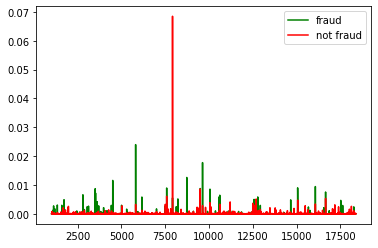

In [12]:
kde_plot(train, 'card1')

- So, the distributions of card1 are quite different between fraud and non-fraud, which means it should be a useful feature for classification.

In [13]:
# important features from kde plot
important_features_v0 = ['card1', 'card2', 'addr1', 'TransactionAmt', 
                         'D15', 'dist1', 'D4', 'D2', 'D10', 'P_emaildomain',
                        'card5', 'C13']

In [14]:
# reference: https://www.kaggle.com/davidcairuz/feature-engineering-lightgbm-w-gpu
# change formats of device information
def device_related_feature(dataframe):
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]

    dataframe['OS_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[0]
    dataframe['version_id_30'] = dataframe['id_30'].str.split(' ', expand=True)[1]

    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    dataframe['screen_width'] = dataframe['id_33'].str.split('x', expand=True)[0].astype(int)
    dataframe['screen_height'] = dataframe['id_33'].str.split('x', expand=True)[1].astype(int)
    dataframe['screen_size'] = dataframe['screen_width'] * dataframe['screen_height']
    
    dataframe['id_23'] = dataframe['id_23'].str.split(':', expand=True)[1]
    
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    dataframe['had_id'] = 1
    
    return dataframe

#train = device_related_feature(train)
#test = device_related_feature(test)

In [15]:
# decimal/log of the transaction amount
train['TransactionAmt_decimal'] = ((train['TransactionAmt'] - train['TransactionAmt'].astype(int)) * 1000).astype(int)
test['TransactionAmt_decimal'] = ((test['TransactionAmt'] - test['TransactionAmt'].astype(int)) * 1000).astype(int)
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

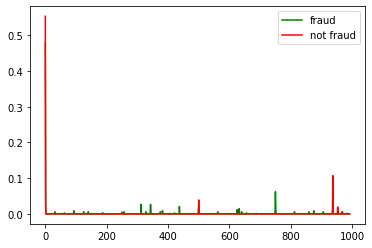

In [16]:
kde_plot(train, 'TransactionAmt_decimal')

In [17]:
# https://www.kaggle.com/fchmiel/day-and-time-powerful-predictive-feature
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

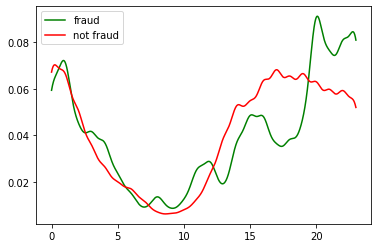

In [18]:
kde_plot(train, 'Transaction_hour')

In [19]:
# some features' count encoding
frequency_encoding_features = list(set().union(important_features_v0))

for feature in frequency_encoding_features:
    # Count encoded for both train and test
    train[feature + '_count_full'] = train[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))
    test[feature + '_count_full'] = test[feature].map(pd.concat([train[feature], test[feature]], ignore_index=True).value_counts(dropna=False))

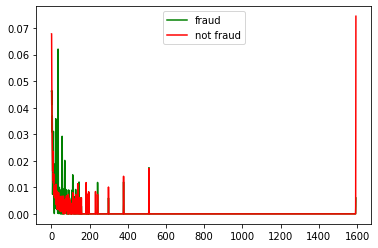

In [20]:
kde_plot(train, 'card1_count_full')

In [21]:
# From v1
# features interaction (from reference script)
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

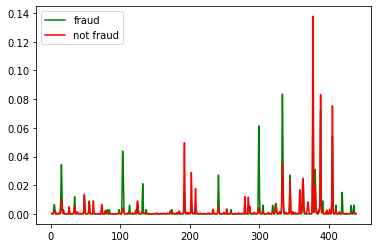

In [22]:
kde_plot(train, 'card5__P_emaildomain')

In [23]:
# null values feature
train['nulls'] = train.isnull().sum(axis=1)
test['nulls'] = test.isnull().sum(axis=1)

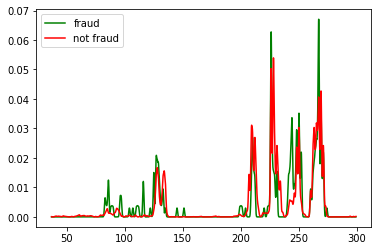

In [24]:
kde_plot(train, 'nulls')

In [25]:
# some statistical features
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

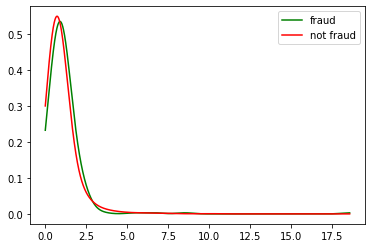

In [26]:
kde_plot(train, 'TransactionAmt_to_mean_card1')

In [27]:
# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [28]:
# email address
train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

In [29]:
train['P_emaildomain'].head(10)

0              NaN
1        gmail.com
2      outlook.com
3        yahoo.com
4        gmail.com
5        gmail.com
6        yahoo.com
7         mail.com
8    anonymous.com
9        yahoo.com
Name: P_emaildomain, dtype: category
Categories (50, object): [aim.com, anonymous.com, aol.com, att.net, ..., yahoo.de, yahoo.es, yahoo.fr, ymail.com]

In [30]:
# important features from feature engineering
important_features_v1 = ['card1_count_full', 'TransactionAmt_to_std_card1', 'TransactionAmt_to_mean_card1',
                        'card2_count_full', 'addr1_count_full', 'TransactionAmt_count_full', 'Transaction_hour',
                        'addr1_card1']

In [31]:
train.to_csv('output/train_v1.csv',index=False)
test.to_csv('output/test_v1.csv',index=False)

# Encoding

In [32]:
train_v1=train.copy()
test_v1=test.copy()

In [33]:
# label encoding
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')
        test[col] = test[col].astype('category')
    
    if train[col].dtype.name == 'category':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [34]:
X = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT', 'TransactionID'], axis=1)
y = train.sort_values('TransactionDT')['isFraud']
test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [35]:
X.head()

TransactionAmt  ProductCD  card1  card2  card3  card4  card5  card6  addr1  \
0            68.5          4  13926    NaN  150.0      1  142.0      0  315.0   
1            29.0          4   2755  404.0  150.0      2  102.0      0  325.0   
2            59.0          4   4663  490.0  150.0      4  166.0      1  330.0   
3            50.0          4  18132  567.0  150.0      2  117.0      1  476.0   
4            50.0          1   4497  514.0  150.0      2  102.0      0  420.0   

   addr2  ...  id_01_count_dist  id_31_count_dist  id_33_count_dist  \
0   87.0  ...              7840               NaN              8753   
1   87.0  ...              7840               NaN              8753   
2   87.0  ...              7840               NaN              8753   
3   87.0  ...              7840               NaN              8753   
4   87.0  ...               596              25.0                15   

   id_36_count_dist  P_emaildomain_1  P_emaildomain_2  P_emaildomain_3  \
0                 4               25                5                2   
1                 4               15                1                2   
2                 4               28                1                2   
3                 4               42                1                2   
4                 2               15                1                2   

   R_emaildomain_1  R_emaildomain_2  R_emaildomain_3  
0               21                6                1  
1               21                6                1  
2               21                6                1  
3               21                6                1  
4               21                6                1  

[5 rows x 482 columns]

# Full GDBT Training

In [36]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.006883242363721497,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47,
          'device': 'cpu', 
          'gpu_use_dp': False,
          'num_threads': 6,
         }

In [37]:
%%time
folds = TimeSeriesSplit(n_splits=5)

aucs = list()
feature_importances = pd.DataFrame()
feature_importances['feature'] = X.columns

training_start_time = time()
for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time()
    print('Training on fold {}'.format(fold + 1))
    
    trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
    clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=200, early_stopping_rounds=500)
    
    feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
    aucs.append(clf.best_score['valid_1']['auc'])
    
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
print('-' * 30)
print('Mean AUC:', np.mean(aucs))
print('-' * 30)

Training on fold 1
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.99589	valid_1's auc: 0.731203
[400]	training's auc: 0.999241	valid_1's auc: 0.736904
[600]	training's auc: 0.999926	valid_1's auc: 0.730828
[800]	training's auc: 1	valid_1's auc: 0.728578
Early stopping, best iteration is:
[307]	training's auc: 0.998112	valid_1's auc: 0.738404
Fold 1 finished in 0:00:02.267000
Training on fold 2
Training until validation scores don't improve for 500 rounds.
[200]	training's auc: 0.984676	valid_1's auc: 0.783686
[400]	training's auc: 0.998505	valid_1's auc: 0.806704
[600]	training's auc: 0.999938	valid_1's auc: 0.826116
[800]	training's auc: 0.999995	valid_1's auc: 0.833272
[1000]	training's auc: 1	valid_1's auc: 0.833683
[1200]	training's auc: 1	valid_1's auc: 0.831654
Early stopping, best iteration is:
[871]	training's auc: 1	valid_1's auc: 0.834176
Fold 2 finished in 0:00:06.934000
Training on fold 3
Training until validation scores don't improve

# Feature importance analysis

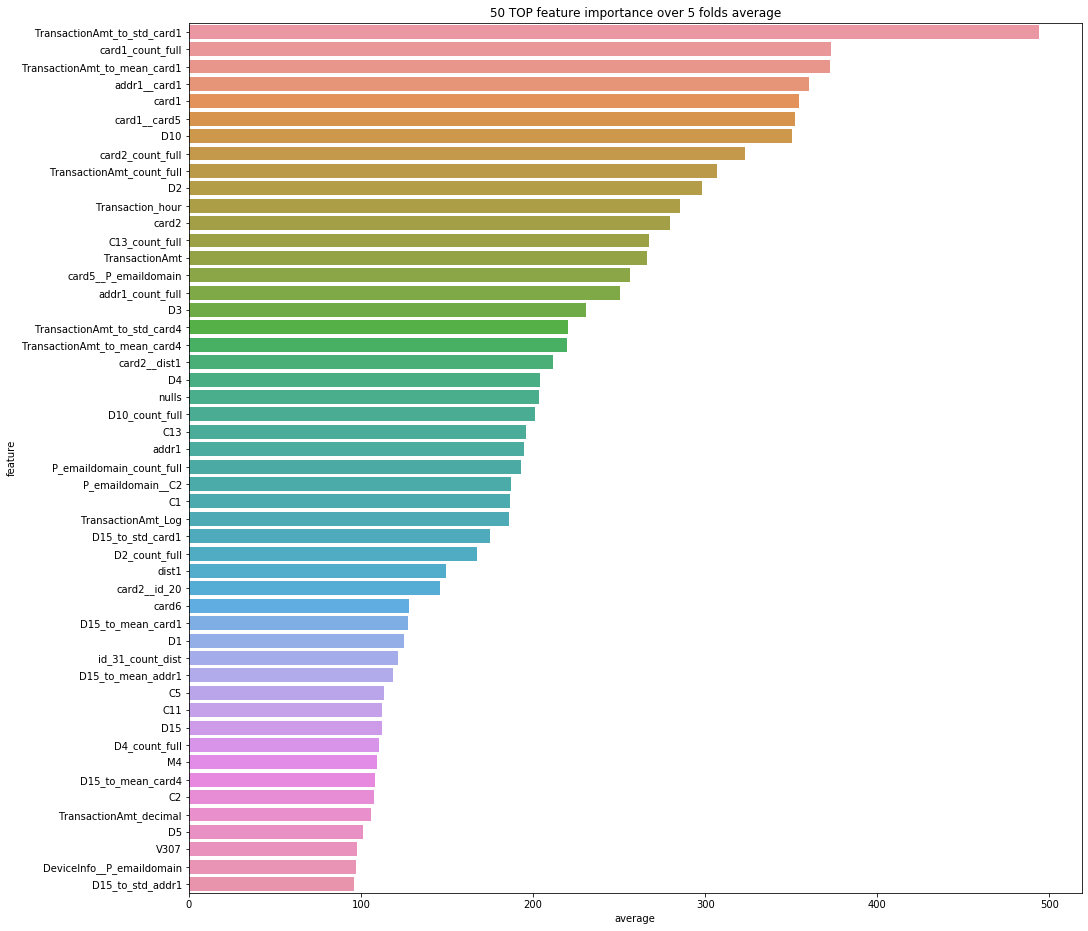

In [38]:
feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
feature_importances.to_csv('output/feature_importances_v' + str(VERSION) + '.csv')

plt.figure(figsize=(16, 16))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));

# Training

In [39]:
%%time
best_iter = clf.best_iteration
clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
clf.fit(X, y)

# NN Training
# DART Training
# KNN Training

# stacking

C:\Users\Administrator\Anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Wall time: 12.4 s


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               device='cpu', feature_fraction=0.3797454081646243,
               gpu_use_dp=False, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=855, num_leaves=491, num_threads=6,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

# Submission

In [40]:
sample_sub['isFraud'] = clf.predict_proba(test)[:, 1]
sample_sub.to_csv('output/ieee_cis_fraud_detection_v' + str(VERSION) + '.csv', index=False)